In [1]:
library(Seurat)
library(ggplot2)
library(ggthemes)
library(ggpubr)
library(pheatmap)
library(stringr)
library(dplyr)
library(ggbeeswarm)
library(RColorBrewer)

load('atlas_20230203.RDATA')

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggbeeswarm' was built under R version 4.1.3"
Warning message:
"package 'RColorBrewer' was built under R version 4.1.3"


In [2]:
Axis_themes <- theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 6),
                     axis.text.x = element_text(size = 6),
                     legend.text = element_text(size =6),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                    axis.line = element_line(size = .355), 
                    axis.ticks = element_line(size = .177))


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4."


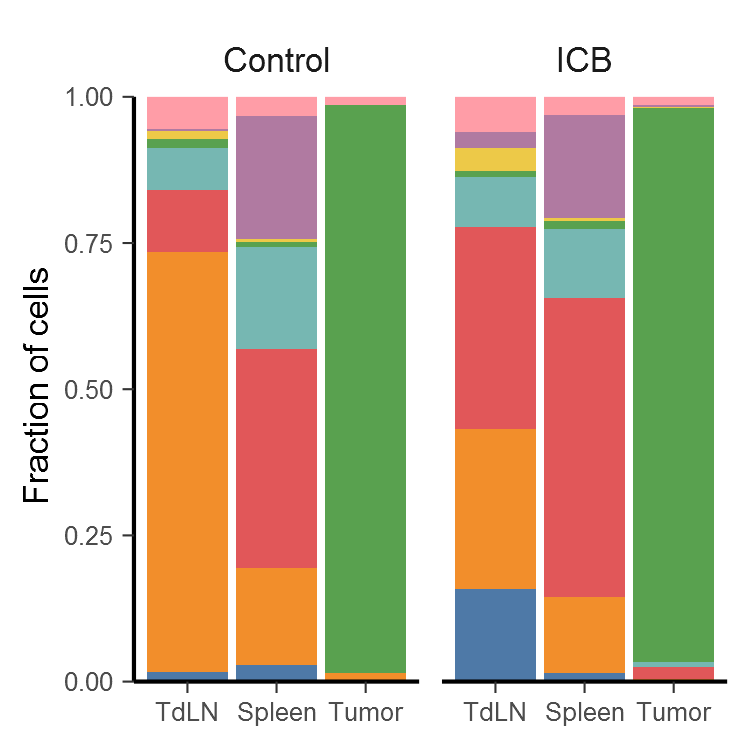

In [3]:
options(repr.plot.res = 300, repr.plot.width = 2.5, repr.plot.height = 2.5)
seurat$tissue = factor(seurat$tissue, levels =c ('TdLN', "Spleen", 'Tumor'))

ggplot(seurat@meta.data, aes(x = tissue, fill = factor(label, levels = rev(levels(seurat@meta.data$cluster_name)) ))) + geom_bar(position =  'fill') + scale_fill_manual(values = phenotype_palette) + theme_classic() + 
Axis_themes + labs(x = c(), y = 'Fraction of cells') + facet_wrap('class') + theme(strip.background = element_blank()) + scale_y_continuous(expand = c(0,0)) + 
guides(fill = FALSE)

`summarise()` has grouped output by 'both', 'class', 'tissue', 'hash'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'tissue'. You can override using the `.groups` argument.


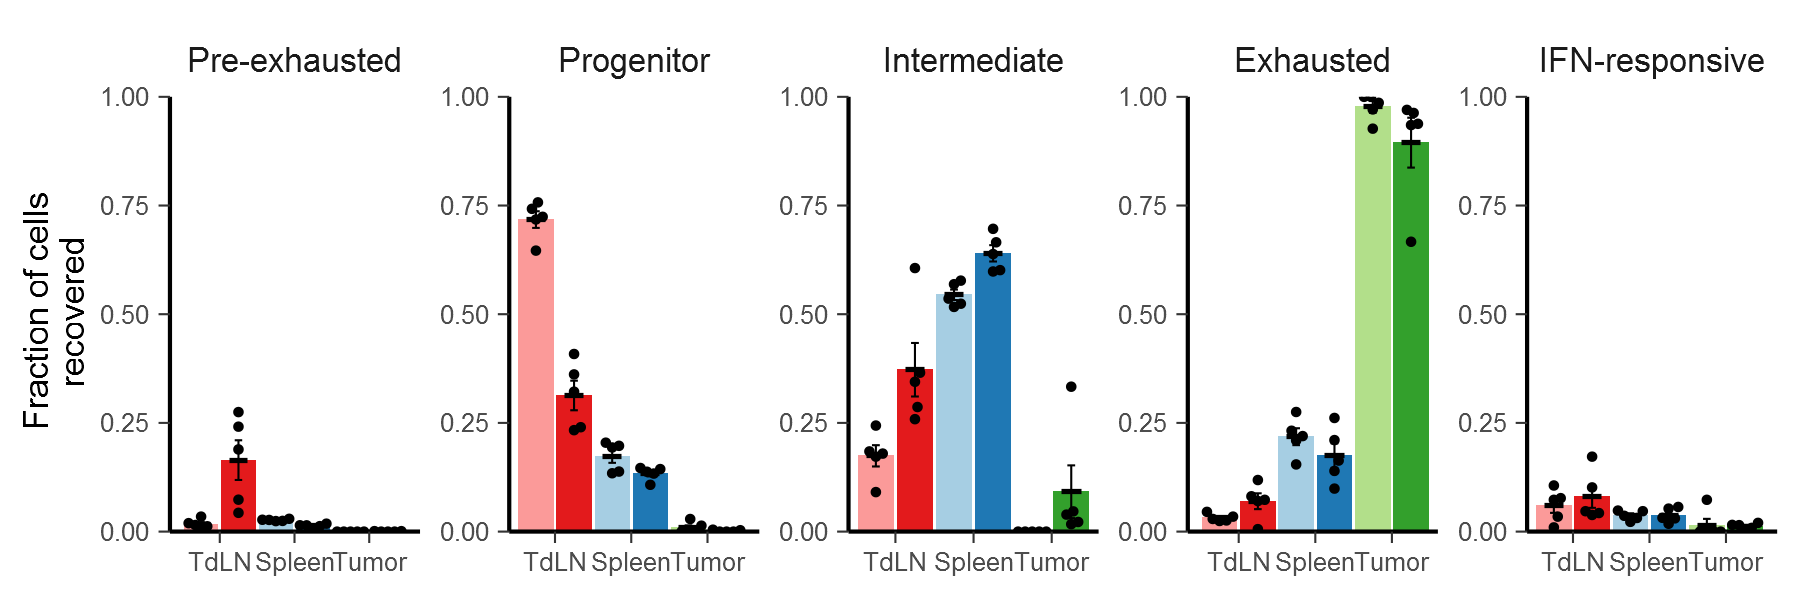

In [20]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 2)

seurat@meta.data$both = factor(paste0(seurat$tissue,'_', seurat$class), levels = c('TdLN_Control', 'TdLN_ICB', 'Spleen_Control', 'Spleen_ICB', 'Tumor_Control', 'Tumor_ICB'))


seurat$stem = factor(as.character(sapply(seurat$label, function(x) str_split(x, '_')[[1]][1])), levels = c('Pre-exhausted','Progenitor', 'Intermediate', 'Exhausted', 'IFN-responsive'))

tissue_palette = brewer.pal(6, 'Paired')[c(5,6,1,2,3,4)]
                     
                     
df = seurat@meta.data %>% group_by(both, class, tissue, hash, stem) %>% summarize(n = n()) %>% mutate(p = n/sum(n)) %>%   tidyr::complete(stem, fill = list(p = 0))
df2 = df %>% group_by(both, class, tissue, stem) %>% summarize(mean = mean(p), sd =sd(p)/sqrt(5)) %>% mutate(ymin = mean-sd, ymax = mean+sd) 
                   

#df2$stem = sapply(df2$label, function(x) str_split(x, '_')[[1]][1])
ggplot(df2, aes(x = tissue, y = mean, group = both, fill = both)) + geom_col(position = position_dodge(width = 1)) + facet_wrap('stem', ncol = 5, scales = 'free') + 
                 scale_fill_manual(values = tissue_palette) + theme_classic() + Axis_themes + scale_y_continuous(expand = c(0,0), limits = c(0,1)) + 
                                         geom_errorbar(data = df2,size = .177, mapping =  aes(x = tissue, y = mean, ymin = ymin, ymax = ymax), color = 'black', width = .2, position = position_dodge(width = 1)) + 
stat_summary(fun.y = mean, color = 'black', geom = 'crossbar', size= .177, width = .5, position = position_dodge(width = 1)) + 
                                         geom_beeswarm(data = df, aes(y = p), dodge.width = 1, size = .3, cex = 3) +
                                         theme(panel.background = element_blank(), strip.background = element_blank()) + guides(color = FALSE, fill = FALSE) + 
                                         labs(x = c(), y = 'Fraction of cells\nrecovered') #+ stat_compare_means(aes(y = mean), comparison = list(c(1,2), c(3,4), c(5,6)))

ggsave('Frequency/bars.pdf', height = 1.5, width = 6.2, useDingbats = FALSE)
                                         
                                  
 #write.table(df, 'Frequency/3a.csv', sep = ',')
write.table(df2, 'Frequency/3a_summary.csv', sep = ',')                                 

#ggplot(df2, aes(x = stem, y = mean, group = tissue, color = both)) + geom_point() + geom_line() + facet_wrap('class') + 
#                  scale_color_manual(values = tissue_palette) + theme_classic() + Axis_themes + scale_y_continuous() + 
#                                 scale_x_discrete(limits = c('Pre-exhausted','Progenitor', 'Intermediate', 'Exhausted', 'IFN_responsive'))

`summarise()` has grouped output by 'stem'. You can override using the `.groups` argument.
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`fun.y` is deprecated. Use `fun` instead."


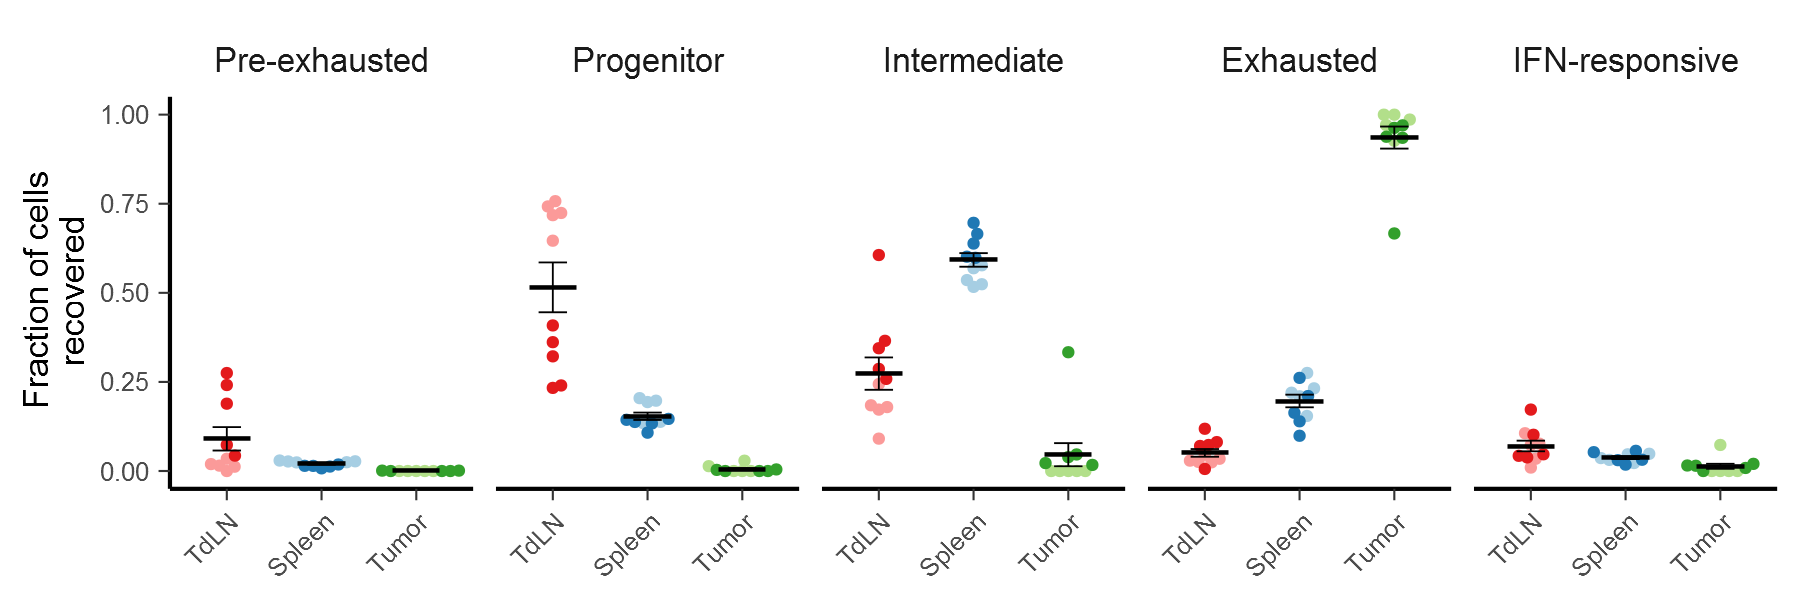

In [45]:
df3 = df %>% group_by(stem, tissue) %>% summarize(mean = mean(p), sd = sd(p)/sqrt(n())) %>% mutate(ymin = mean-sd, ymax = mean+sd)
ggplot(df, aes(x = tissue, y = p, color = both)) + geom_beeswarm(cex = 3, size = .5) + facet_wrap('stem', ncol = 5) + theme_classic() + scale_color_manual(values = tissue_palette) + theme_classic() + Axis_themes + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + guides(color = FALSE) + stat_summary(fun.y = mean, geom = 'crossbar', color = 'black',  size = .155, width = .5) + 
geom_errorbar(data = df3, aes(ymin = ymin, ymax = ymax, y = mean), color = 'black', size = .155, width = .3) + labs(x = c(), y = 'Fraction of cells\nrecovered') + 
theme(strip.background = element_blank())

ggsave('Frequency/bars.pdf', height =2 , width = 6.2, useDingbats = FALSE)


In [51]:
library(FSA)

sub = df %>% filter(stem == 'Pre-exhausted')
test = aov(p~tissue, data = sub)
TukeyHSD(test)
sub = df %>% filter(stem == 'Progenitor')
test = aov(p~tissue, data = sub)
TukeyHSD(test)

sub = df %>% filter(stem == 'Intermediate')
test = aov(p~tissue, data = sub)
TukeyHSD(test)
sub = df %>% filter(stem == 'Exhausted')
test = aov(p~tissue, data = sub)
TukeyHSD(test)

sub = df %>% filter(stem == 'IFN-responsive')
test = aov(p~tissue, data = sub)
TukeyHSD(test)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = p ~ tissue, data = sub)

$tissue
                    diff         lwr          upr     p adj
Spleen-TdLN  -0.07034341 -0.13704805 -0.003638768 0.0372143
Tumor-TdLN   -0.09010595 -0.15681059 -0.023401314 0.0065702
Tumor-Spleen -0.01976255 -0.08646719  0.046942094 0.7453353


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = p ~ tissue, data = sub)

$tissue
                   diff        lwr          upr     p adj
Spleen-TdLN  -0.3616882 -0.5048536 -0.218522777 0.0000031
Tumor-TdLN   -0.5103194 -0.6534848 -0.367153970 0.0000000
Tumor-Spleen -0.1486312 -0.2917966 -0.005465799 0.0407011


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = p ~ tissue, data = sub)

$tissue
                   diff        lwr        upr     p adj
Spleen-TdLN   0.3190640  0.1996594  0.4384687 0.0000012
Tumor-TdLN   -0.2274272 -0.3468318 -0.1080225 0.0001845
Tumor-Spleen -0.5464912 -0.6658959 -0.4270865 0.0000000


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = p ~ tissue, data = sub)

$tissue
                  diff        lwr       upr     p adj
Spleen-TdLN  0.1456738 0.07016998 0.2211775 0.0001567
Tumor-TdLN   0.8848670 0.80936324 0.9603708 0.0000000
Tumor-Spleen 0.7391933 0.66368949 0.8146970 0.0000000


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = p ~ tissue, data = sub)

$tissue
                    diff         lwr          upr     p adj
Spleen-TdLN  -0.03270621 -0.06719603  0.001783617 0.0655939
Tumor-TdLN   -0.05701452 -0.09150435 -0.022524697 0.0009635
Tumor-Spleen -0.02430831 -0.05879814  0.010181511 0.2064436


`summarise()` has grouped output by 'both', 'class', 'tissue', 'hash'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'both', 'class', 'tissue'. You can override using the `.groups` argument.
Warning message in wilcox.test.default(c(0.971014492753623, 0.986301369863014, 0.926829268292683, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(0.971014492753623, 0.986301369863014, 0.926829268292683, :
"cannot compute exact p-value with ties"


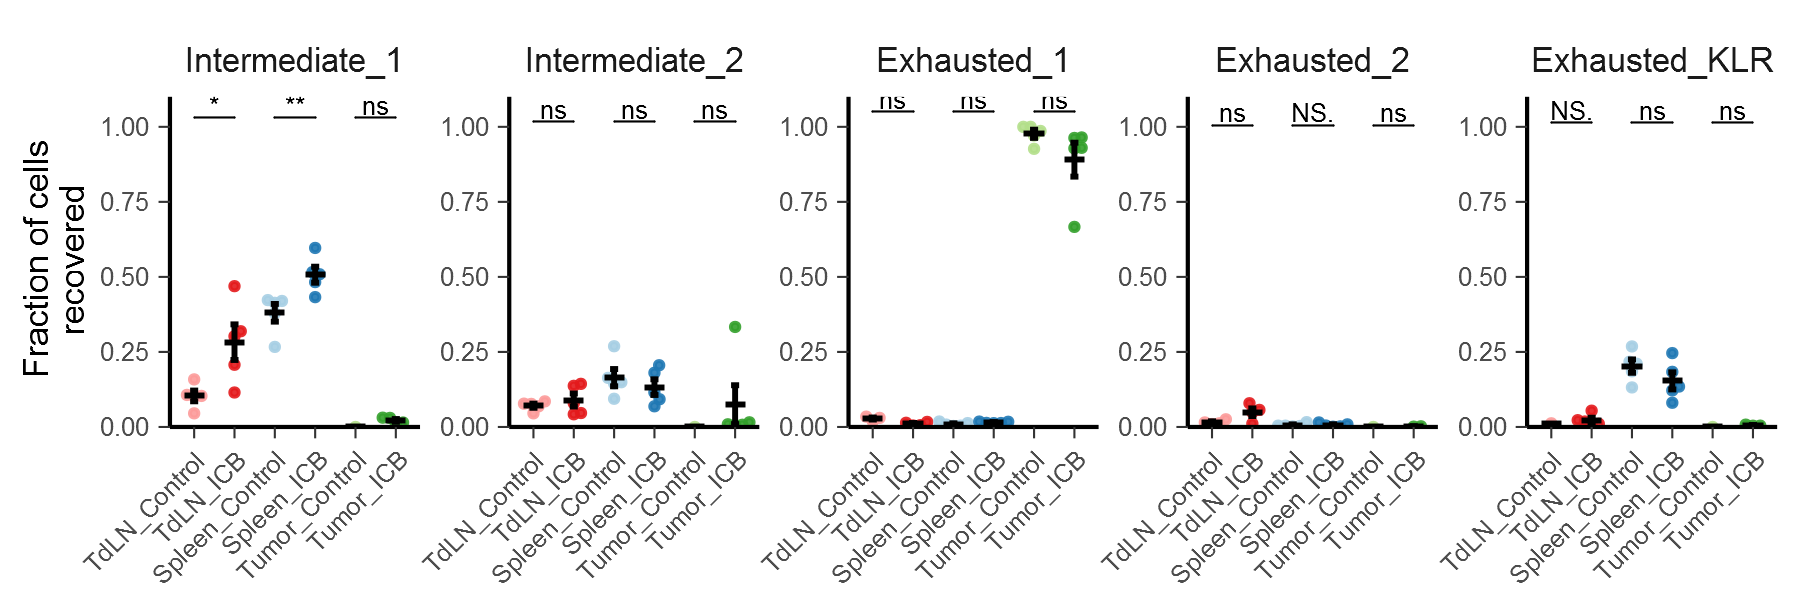

In [22]:
# library(dplyr)
library(ggbeeswarm)
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 2)

seurat@meta.data$both = factor(paste0(seurat$tissue,'_', seurat$class), levels = c('TdLN_Control', 'TdLN_ICB', 'Spleen_Control', 'Spleen_ICB', 'Tumor_Control', 'Tumor_ICB'))

df = seurat@meta.data %>% group_by(both, class, tissue, hash, label) %>% summarize(n = n()) %>% mutate(p = n/sum(n))  %>%
group_by(both, class, tissue) %>% tidyr::complete(label, fill = list(p = 0)) %>%
#filter(!label %in% c('Exhausted_1', 'Exhausted_2', 'Proliferating_1', 'Proliferating_2'))
filter(label%in% c('Exhausted_1', 'Exhausted_2', 'Exhausted_KLR', 'Intermediate_1', 'Intermediate_2'))

df2 = df %>% group_by(both, class, tissue, label) %>% summarize(mean = mean(p), sd =sd(p)/sqrt(5)) %>% mutate(ymin = mean-sd, ymax = mean+sd)

g1 = ggplot(df, aes(x = both, y = p, color = both))  + facet_wrap('label', ncol = 5, scales = 'free') + theme_bw() + Axis_themes + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_color_manual(values = tissue_palette) + ggpubr::stat_compare_means(comparison = list(c(1,2), c(3,4), c(5,6)), label.y = c(1,1,1), label = 'p.signif', bracket.size = .177, tip.length = 0) + 
labs(x = c(), y = 'Fraction of cells\nrecovered') + guides(color = FALSE) + scale_y_continuous(expand = c(0,0), limits = c(0, 1.1)) +
theme(axis.line=element_line()) + geom_beeswarm(cex = 3, size = .5, alpha = .9, fill = 'black') + 
geom_errorbar(data = df2,mapping =  aes(x = both, y = mean, ymin = ymin, ymax = ymax), color = 'black', width = .2) + 
stat_summary(fun.y = mean, color = 'black', geom = 'crossbar', size= .2, width = .5) + theme(panel.background = element_blank(), strip.background = element_blank(), plot.background = element_blank(), 
                                                                                            panel.border = element_blank(), panel.grid = element_blank()) 

g1$layers[[1]]$aes_params$textsize <- 2.1167
g1

write.table(df, 'frequency/3b.csv', sep = ',')

ggsave('Frequency/int-exh.pdf', height = 2, width = 7.2, useDingbats = FALSE)

In [35]:
pheno = c('Intermediate_1', 'Intermediate_2', 'Exhausted_1', 'Exhausted_2', 'Exhausted_KLR')
tissue = c('TdLN', 'Spleen', 'Tumor')
for (a in pheno) {
    for(b in tissue) {
        print(wilcox.test(p~class, data = df %>% filter(tissue == b, label == a)))
    }
        
}




	Wilcoxon rank sum exact test

data:  p by class
W = 1, p-value = 0.01587
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.4
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 10, p-value = 0.6905
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 16, p-value = 0.5476
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 12, p-value = 0.05714
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:

Warning message in wilcox.test.default(x = c(0.971014492753623, 0.986301369863014, :
"cannot compute exact p-value with ties"



	Wilcoxon rank sum test with continuity correction

data:  p by class
W = 21, p-value = 0.09369
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 3, p-value = 0.2
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 12, p-value = 1
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.6667
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 2, p-value = 1
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 19, p-value = 0.2222
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.5
alternative hypothesis: true location shift is not equal to 0



In [27]:
wilcox.test(p~class, data = df %>% filter(tissue == 'TdLN', label == 'Intermediate_1'))


	Wilcoxon rank sum exact test

data:  p by class
W = 0, p-value = 0.007937
alternative hypothesis: true location shift is not equal to 0


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`fun.y` is deprecated. Use `fun` instead."
Warning message in wilcox.test.default(c(0.971014492753623, 0.986301369863014, 0.926829268292683, :
"cannot compute exact p-value with ties"


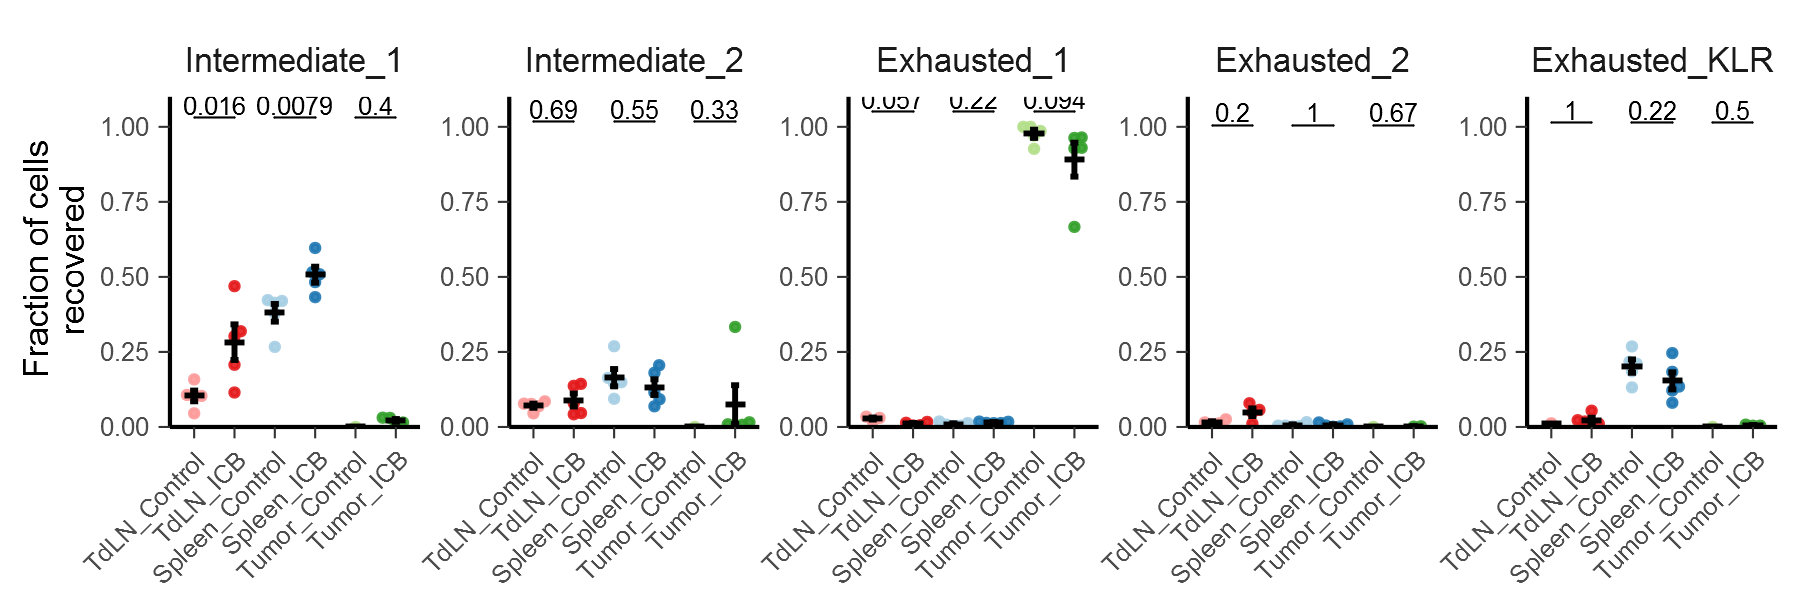

In [55]:
g1 = ggplot(df, aes(x = both, y = p, color = both))  + facet_wrap('label', ncol = 5, scales = 'free') + theme_bw() + Axis_themes + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_color_manual(values = tissue_palette) + ggpubr::stat_compare_means(comparison = list(c(1,2), c(3,4), c(5,6)), label.y = c(1,1,1), label = 'p.value', bracket.size = .177, tip.length = 0) + 
labs(x = c(), y = 'Fraction of cells\nrecovered') + guides(color = FALSE) + scale_y_continuous(expand = c(0,0), limits = c(0, 1.1)) +
theme(axis.line=element_line()) + geom_beeswarm(cex = 3, size = .5, alpha = .9, fill = 'black') + 
geom_errorbar(data = df2,mapping =  aes(x = both, y = mean, ymin = ymin, ymax = ymax), color = 'black', width = .2) + 
stat_summary(fun.y = mean, color = 'black', geom = 'crossbar', size= .2, width = .5) + theme(panel.background = element_blank(), strip.background = element_blank(), plot.background = element_blank(), 
                                                                                            panel.border = element_blank(), panel.grid = element_blank()) 
g1$layers[[1]]$aes_params$textsize <- 2.1167
g1


In [57]:
options(repr.plot.res = 300, repr.plot.width = 8, repr.plot.height = 4)

seurat@meta.data$both = factor(paste0(seurat$tissue,'_', seurat$class), levels = c('TdLN_Control', 'TdLN_ICB', 'Spleen_Control', 'Spleen_ICB', 'Tumor_Control', 'Tumor_ICB'))

df = seurat@meta.data %>% group_by(both, class, tissue, hash, label) %>% summarize(n = n()) %>% mutate(p = n/sum(n))  %>%
group_by(both, class, tissue) %>% tidyr::complete(label, fill = list(p = 0)) 

df2 = df %>% group_by(both, class, tissue, label) %>% summarize(mean = mean(p), sd =sd(p)/sqrt(5)) %>% mutate(ymin = mean-sd, ymax = mean+sd)
tissue_palette = brewer.pal(6, 'Paired')[c(1,2,5,6)]




ggplot(df2, aes(x = label, y = mean, group = both, color = both)) + geom_line() + theme_classic() + theme(axis.text.x = element_text(angle =45, hjust = 1)) +


ERROR: Error in parse(text = x, srcfile = src): <text>:16:0: unexpected end of input
14: ggplot(df2, aes(x = label, y = mean, group = both, color = both)) + geom_line() + theme_classic() + theme(axis.text.x = element_text(angle =45, hjust = 1)) +
15: 
   ^



         0          4 background 
        11         11       9570 

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"Removed 9570 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 9570 rows containing missing values (geom_text_repel)."


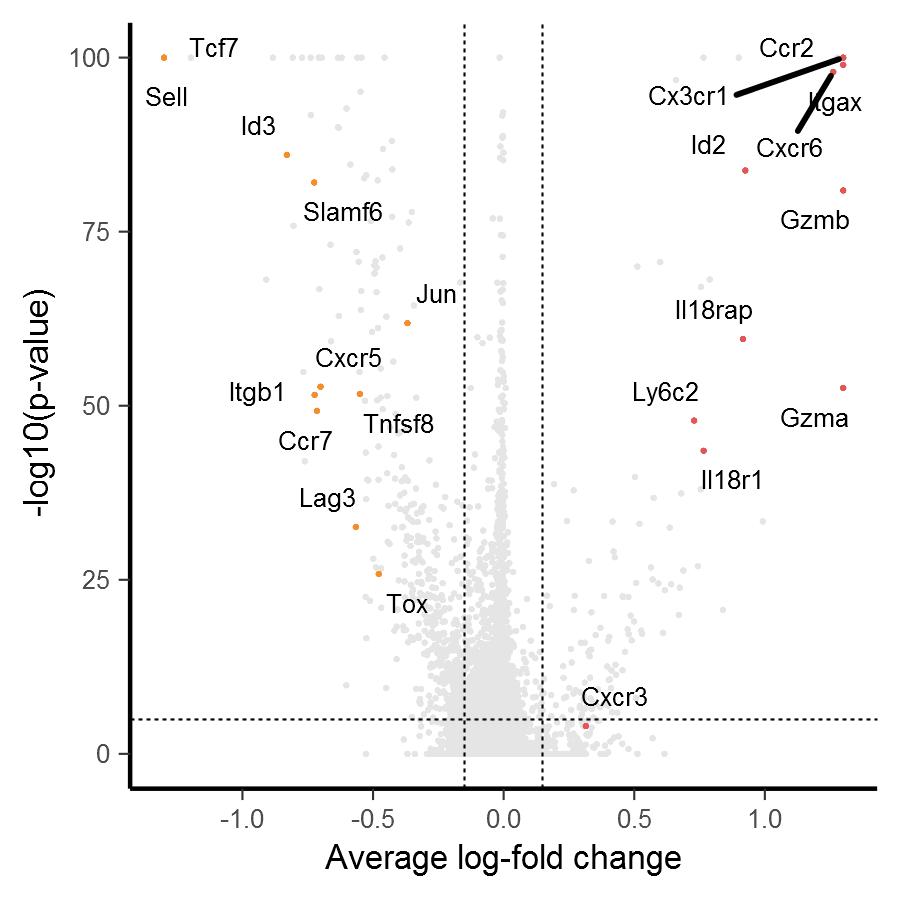

In [32]:
library(ggrepel)
library(stringr)
library(ggrastr)
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)
DefaultAssay(seurat) = 'integrated'
Idents(seurat) = 'cluster_name'
#markers.proint1 = FindMarkers(seurat,c('Progenitor'), c('Intermediate_1'), logfc.threshold = 0)
markers.plot =c("Sell", 'Ccr2', 'Tcf7', 'Cxcr6', 'Id2', 'Itgax', 'Slamf6', 'Cxcr3', 'Cx3cr1', 'Il18r1', 'Id3', 'Gzmb', 'Cxcr5', 'Il18rap', 'Gzma', 'Jun', 'Ly6c2', 'Ccr7', 'Tnfsf8', 'Lag3', 'Tox', 'Itgb1')
a = markers.proint1
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA
a$avg_log2FC = -a$avg_log2FC
a$avg_log2FC[a$avg_log2FC < -1.3] = -1.3
a$avg_log2FC[a$avg_log2FC > 1.3] = 1.3

a$color = 'background'
a$color[!is.na(a$label)] = '4'
a$color[!is.na(a$label) & (a$avg_log2FC < 0)] = '0'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-100] = 1e-100

table(a$color)
a = a[order(!is.na(a$label)),]

ggplot(a, aes(x = avg_log2FC, y = -log10(p_val_plot), color = color)) + geom_point_rast(size = .7, raster.dpi = 1000, stroke = 0) + theme_classic() + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c(unname(phenotype_palette[c( 'Progenitor', 'Intermediate_1' )]), 'grey90')) + 
geom_hline(yintercept = 5, linetype = 'dashed', size = .177) + geom_vline(xintercept = .15, linetype = 'dashed', size = .177) + geom_vline(xintercept = -.15, linetype = 'dashed', size = .177) + 
theme(axis.line = element_line(size = .38), axis.ticks = element_line(size = .177))
ggsave('frequency/pro_vs_int1.pdf', height = 2.3, width = 2.3, useDingbats = FALSE)
#write.csv(markers.exh.1, 'exh1_vs_exh2.csv')




         0          4 background 
         7         11       8013 

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"Removed 8013 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 8013 rows containing missing values (geom_text_repel)."


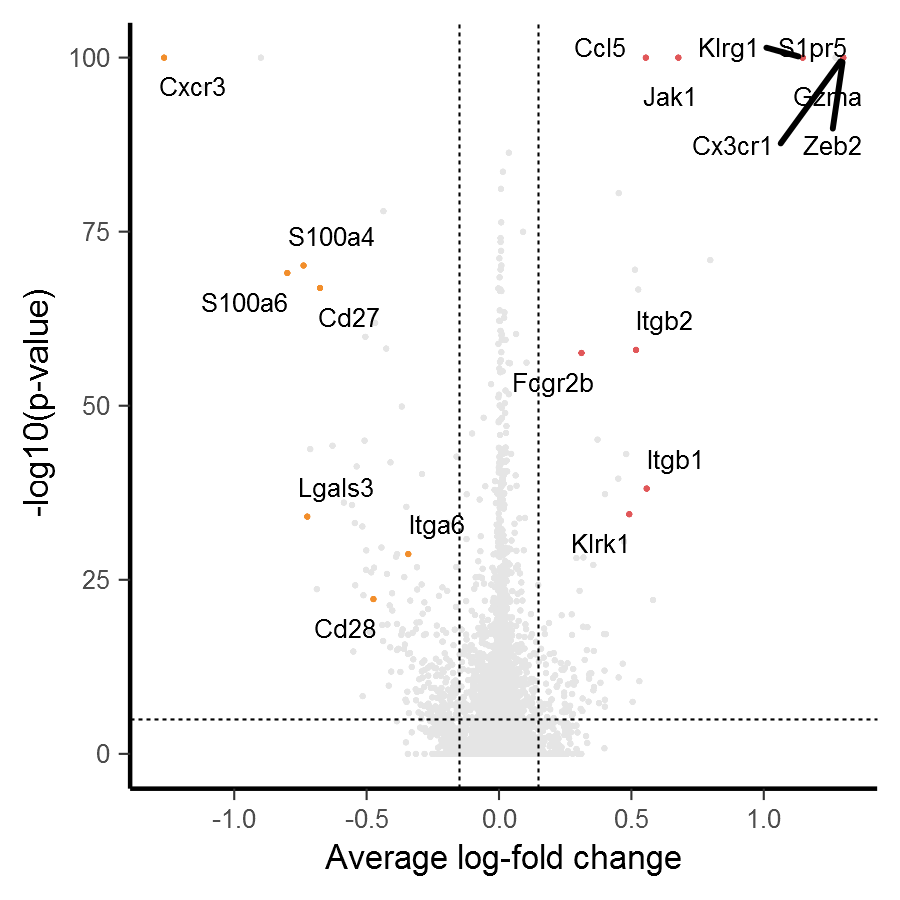

In [33]:
library(ggrepel)
library(stringr)
library(ggrastr)
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)
DefaultAssay(seurat) = 'integrated'
Idents(seurat) = 'cluster_name'
#markers.intklr = FindMarkers(seurat,c('Exhausted_KLR'), c('Intermediate_1'), logfc.threshold = 0)
markers.plot =c('S1pr5', 'Zeb2', 'Gzma', 'Ccl5', 'Cd27', 'Cx3cr1', 'Cxcr3','Itgb1', 'Itga6', 'Klrg1', 'Jak1', 'Itgb2', 'Klrk1', 'Cd28', 'Fcgr2b', 'S100a4', 'S100a6', 'Lgals3')
a = markers.intklr
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA
a$avg_log2FC[a$avg_log2FC < -1.3] = -1.3
a$avg_log2FC[a$avg_log2FC > 1.3] = 1.3

a$color = 'background'
a$color[!is.na(a$label)] = '4'
a$color[!is.na(a$label) & (a$avg_log2FC < 0)] = '0'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-100] = 1e-100

table(a$color)
a = a[order(!is.na(a$label)),]

ggplot(a, aes(x = avg_log2FC, y = -log10(p_val_plot), color = color)) + geom_point_rast(size = .7, raster.dpi = 1000, stroke = 0) + theme_classic() + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c(unname(phenotype_palette[c( 'Progenitor', 'Intermediate_1' )]), 'grey90')) + 
geom_hline(yintercept = 5, linetype = 'dashed', size = .177) + geom_vline(xintercept = .15, linetype = 'dashed', size = .177) + geom_vline(xintercept = -.15, linetype = 'dashed', size = .177) + 
theme(axis.line = element_line(size = .38), axis.ticks = element_line(size = .177))
ggsave('frequency/int1_klr.pdf', height = 2.3, width = 2.3, useDingbats = FALSE)
#write.csv(markers.exh.1, 'exh1_vs_exh2.csv')



In [83]:
library(pheatmap)
options(repr.plot.width = 3, repr.plot.height =2.3,repr.plot.res = 300 )
DefaultAssay(seurat) = 'integrated'

library(dplyr)

#genes = c('Ccl5', 'Ccr2', 'Itga4', 'Id2',"Cxcr3", 'Cd27', 'Ly6e', 'Lgals3', 'Gzmk', 'Tcf7', 'Sell', 'Rpl12', 'Id3', 'Il7r', 'Havcr2', 'Pdcd1', 'Ifng', 'Gzmb', 'Lag3', 
#         'Cx3cr1', 'Gzma', 'S1pr5', 'Zeb2', 'Klrg1' ,'Mki67', 'Cenpa', 'Mcm5', 'Cenpe', 'Lsp1','Itgae', 'Itgb1', 'Il18r1', 'Cxcr6', 'S1pr1', 'Hist1h1b', 'Hist1h3c', 'Tuba1b', 'Tubb5', 'Top2a', 
 #        'Ncl', 'Eif5a', 'Npm1', 'Hsp90ab1', 'Cct3',"Ifit1", 'Isg15', 'Stat1', 'Irf7', 'Oas3', 'Tox', 'Ccl3', 'Entpd1', 'Tigit', 'Ccl4')

genes = c(  'Cxcr3', 'Cx3cr1')

genes = genes[genes %in% rownames(GetAssayData(seurat))]
data = GetAssayData(seurat)[genes,] %>% as.matrix()  %>% t()%>% as.data.frame()
data$cluster =seurat$cluster_name
data$hash = seurat$hash
data$letter = seurat$class
data = data[data$cluster %in% c('Progenitor', 'Intermediate_1', 'Exhausted_KLR'),]
data = data %>%  group_by(cluster, letter, hash) %>% summarize_all(.funs = mean)

plot_data  = data[,-c(1,2,3)]
#plot_data = scale(plot_data)

rownames(plot_data)= paste0(data$cluster, data$letter, data$hash)

meta.data = data.frame(row.names = rownames(plot_data), cluster = data$cluster)
#plot_data[plot_data < -1.5] = -1.5
#plot_data[plot_data > 2] = 2
options(repr.plot.width = 2)
pheatmap(plot_data , cluster_rows = FALSE, cluster_cols = FALSE, annotation_row = meta.data, show_rownames = FALSE, 
         annotation_colors = list(cluster = phenotype_palette), color = colorRampPalette(c('white', brewer.pal(9, 'OrRd')))(100), gaps_row = c(10, 20), 
        fontsize = 6, border_color = NA, angle_col = 45, filename = 'Frequency/flowmark.pdf', width =2, height = 2.3)

Warning message:
"Setting row names on a tibble is deprecated."


In [34]:
save.image('figure_frequency.RDATA')